In [109]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract

Populating the interactive namespace from numpy and matplotlib


In [110]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/44.jpg")
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

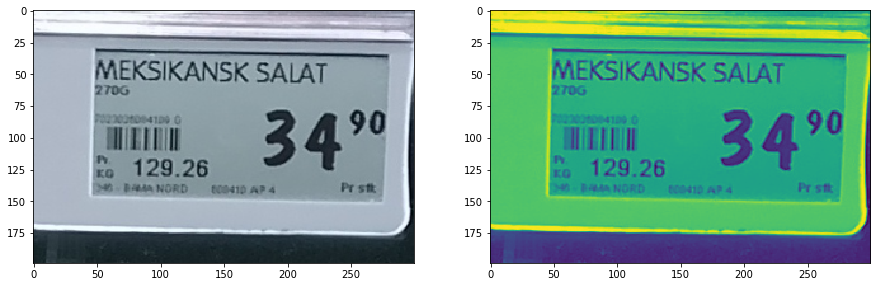

In [111]:
fig = plt.figure()
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
axs[0].imshow(image)
axs[1].imshow(gray)
fig.show()

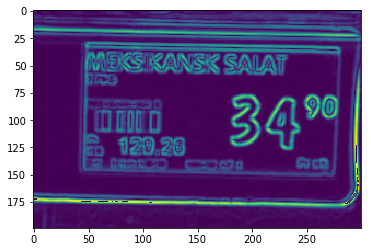

In [112]:
grads = []
for dx, dy in ((1, 0), (0, 1)):
    grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=dx, dy=dy,ksize=9)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (255 * ((grad - minVal) / (maxVal - minVal)))
    grad = grad.astype("uint8")
    #grad = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    grads.append(grad)

grad = grads[0] + grads[1]
plt.imshow(grad)
plt.show()

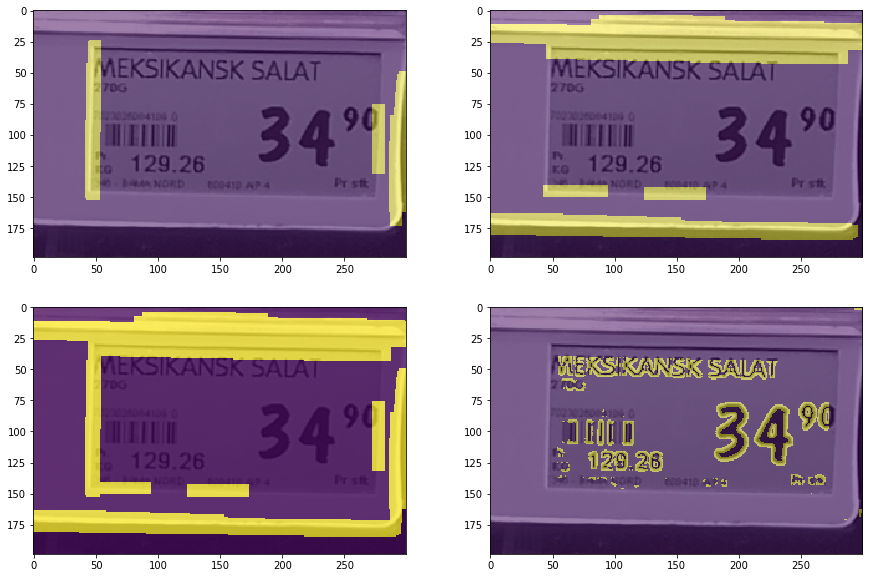

In [113]:
fig = plt.figure()
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs = axs.flatten()

rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
lines = [None, None]
for idx, (ax, kern) in enumerate(zip(axs, (cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40)),
                                           cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))))):
    lines[idx] = cv2.erode(grad, kern)
    lines[idx] = cv2.threshold(lines[idx], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    lines[idx] = cv2.dilate(lines[idx], rectKern)
    lines[idx] = cv2.dilate(lines[idx], kern)

    ax.imshow(image, alpha=1)
    ax.imshow(lines[idx], alpha=0.5)

lines = lines[0] + lines[1]
objgrads = cv2.threshold(cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] - lines, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

axs[2].imshow(image, alpha=1)
axs[2].imshow(lines, alpha=0.5)
axs[2].imshow(lines, alpha=0.5)
axs[3].imshow(image, alpha=1)
axs[3].imshow(objgrads, alpha=0.5)

fig.show()

In [114]:
cnts = cv2.findContours(objgrads.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

rects = [cv2.boundingRect(c) for c in cnts]

In [132]:
def boxDist(r1, r2):
    """Distance from center of right edge of r1 to center of left edge of r2 divided by their (max) height."""
    return sqrt((r1[0] + r1[2] - r2[0])**2 + 
                (r1[1] + r1[3] / 2. - (r2[1] + r2[3] / 2.))**2) / float(max(r1[3], r2[3]))

def boxDiff(r1, r2):
    """'Unsigned' height ratio between boxes"""
    if r1[3] < r2[3]:
        return r1[3] / float(r2[3])
    else:
        return r2[3] / float(r1[3])

lines = []
for ridx, r in sorted(enumerate(rects), lambda a, b: cmp(a[1][0], b[1][0])):
    boxdists = sorted(((boxDist(rects[l[-1]], r),
                        boxDiff(rects[l[-1]], r),
                        lidx)
                       for lidx, l in enumerate(lines)),
                      lambda a, b: cmp(a[0], b[0]))
    boxdists = [(dist, diff, lidx)
                for (dist, diff, lidx) in boxdists
                if dist < 1 and diff > 0.75]
    if boxdists:
        dist, diff, lidx = boxdists[0]
        #print "%s added to %s after %s with distance %s and diff %s" % (ridx, lidx, lines[lidx][-1], dist, diff)
        lines[lidx].append(ridx)
    else:
        #print "%s added to new line %s" % (ridx, len(lines))
        lines.append([ridx])

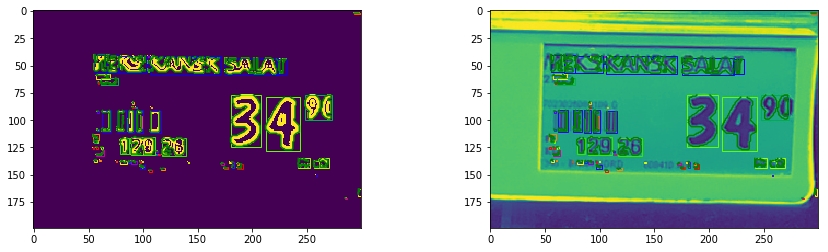

In [133]:
def drawLines(ax):
    cmap = plt.get_cmap("prism")
    for idx, l in enumerate(lines):
        color = cmap(idx / float(len(lines)))
        for bidx in l:
            b = rects[bidx]
            ax.add_patch(patches.Rectangle((b[0],b[1]),b[2],b[3], fill=False, edgecolor=color))

def drawCountours(ax):
    for c in cnts:
        ax.plot(c[:,0,0], c[:,0,1], color="green")

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrads)
axs[1].imshow(gray)
for idx in (0, 1):
    drawCountours(axs[idx])
    drawLines(axs[idx])


    fig.show()

In [134]:
def bbox2pos(b):
    b = list(b)
    b[2] += b[0]
    b[3] += b[1]
    return b

def pos2bbox(p):
    p = list(p)
    p[2] -= p[0]
    p[3] -= p[1]
    return tuple(p)

lineboxes = []
for line in lines:
    pos = bbox2pos(rects[line[0]])
    for bidx in line[1:]:
        p = bbox2pos(rects[bidx])
        if p[0] < pos[0]:
            pos[0] = p[0]
        if p[1] < pos[1]:
            pos[1] = p[1]
        if p[2] > pos[2]:
            pos[2] = p[2]
        if p[3] > pos[0]:
            pos[3] = p[3]
    lineboxes.append(pos2bbox(pos))

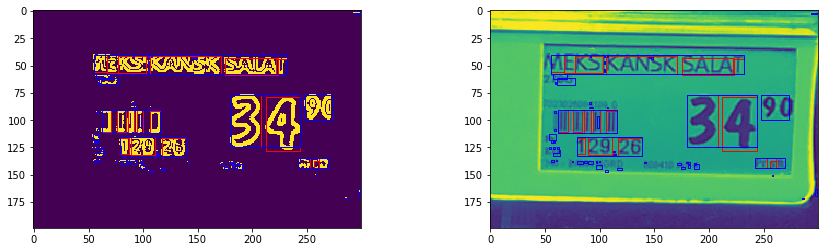

In [138]:
def drawLineParts(ax):
    for idx, l in enumerate(lines):
        for bidx in l:
            b = rects[bidx]
            ax.add_patch(patches.Rectangle((b[0],b[1]),b[2],b[3], fill=False, edgecolor="red"))

def drawLineBoxes(ax):
    cmap = plt.get_cmap("prism")
    for b in lineboxes:
        ax.add_patch(patches.Rectangle((b[0],b[1]),b[2],b[3], fill=False, edgecolor="blue"))

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrads)
axs[1].imshow(gray)
for idx in (0, 1):
    drawLineParts(axs[idx])
    drawLineBoxes(axs[idx])
    fig.show()

In [139]:
from PIL import Image
for b in lineboxes:
    (x, y, w, h) = b
    if w < 10 or h < 10: continue
    x -= 5
    y -= 5
    w += 10
    h += 10
    roi = gray[y:y + h, x:x + w]
    if not roi.shape[0] or not roi.shape[1]: continue
    print pytesseract.image_to_string(Image.fromarray(roi))


M'EKSJKANSK SAIAT
hm
129.26
34
90
